# "Introduction"

Implementation of the VMC algorithm for Problem 1. For results see the sections below.

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [88]:
M = 300 #number of random walkers
R = np.zeros((2*M,3))
for m in range(2*M):
    for d in range(3):
        R[m,d] = np.random.uniform(-0.5, 0.5)

In [493]:
def psi_T(vec_r_1, vec_r_2, alpha, kappa, beta):
    r_1 = np.linalg.norm(vec_r_1)
    r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_1 - vec_r_2
    r_12 = np.linalg.norm(vec_r12)
    pref = beta*r_12/(1+alpha*r_12)
    psi = np.exp(-kappa*r_1)*np.exp(-kappa*r_2)*np.exp(pref)
    return psi

def Fokker_planck(vec_r_1, vec_r_2, alpha, kappa, beta):
    r_1 = np.linalg.norm(vec_r_1)
    vec_r12 = vec_r_1 - vec_r_2
    r_12 = np.linalg.norm(vec_r12)
    u = 1 + alpha*r_12
    factor = beta*(((u/r_12)-alpha)/u**2)
    force_1 = 2*(-kappa*(vec_r_1/r_1)+factor*vec_r12)
    return np.array(force_1)

def greens_function(vec_r_try_1, vec_r_try_2, vec_r_old_1, vec_r_old_2, alpha, beta, kappa, delta_t):    
    f_try_1 = Fokker_planck(vec_r_try_1, vec_r_try_2, alpha, kappa, beta)
    f_old_1 = Fokker_planck(vec_r_old_1, vec_r_old_2, alpha, kappa, beta)
    f_try_2 = Fokker_planck(vec_r_try_2, vec_r_try_1, alpha, kappa, beta)
    f_old_2 = Fokker_planck(vec_r_old_2, vec_r_old_1, alpha, kappa, beta)
    
    c_try_1 = np.linalg.norm(vec_r_try_1 - vec_r_old_1 + f_try_1*delta_t/2)**2
    c_try_2 = np.linalg.norm(vec_r_try_2 + vec_r_old_2 - f_try_2*delta_t/2)**2
    c_old_1 = np.linalg.norm(vec_r_old_1 - vec_r_try_1 + f_old_1*delta_t/2)**2
    c_old_2 = np.linalg.norm(vec_r_old_2 + vec_r_try_2 - f_old_2*delta_t/2)**2
    
    c = +c_try_1+c_try_2-c_old_1-c_old_2
    pref = (1/np.sqrt(2*np.pi*delta_t)) #Should cancel out
    return np.exp(-c/2*delta_t)

def metropolis_algorithm(initial_state, num_trials, s, alpha, beta, kappa, use_FP = False, delta_t=1, disable_tqdm = False):
    sequence_states = [initial_state]
    list_probs = []
    for _ in tqdm(range(num_trials), disable=disable_tqdm):
        next_sequence, prob = metropolis_step(sequence_states[-1], alpha, beta, s, kappa, delta_t=delta_t, use_FP=use_FP)
        sequence_states.append(next_sequence)
        list_probs.append(prob)
    return np.array(sequence_states), list_probs
   
def metropolis_step(current_state, alpha, beta, s, kappa, delta_t = 1, use_FP=False):
    trial_configuration = current_state.copy()
    new_state = np.zeros(current_state.shape)
    for i in range(M):
        which_particle = np.random.choice([0,M])
        if use_FP:
            trial_configuration[i+which_particle] += Fokker_planck(current_state[i+which_particle], current_state[i+M-which_particle], alpha, kappa, beta)*delta_t/2 
            trial_configuration[i-which_particle+M] += Fokker_planck(current_state[i-which_particle+M], current_state[i+which_particle], alpha, kappa, beta)*delta_t/2 
            trial_configuration[i-which_particle+M] += np.random.normal(0, 1, 3)*np.sqrt(delta_t)
            trial_configuration[i+which_particle] += np.random.normal(0,1, 3)*np.sqrt(delta_t)
        else:
            trial_configuration[i+which_particle] += np.random.uniform(low=-s/2, high=s/2, size=3)
        p = psi_T(trial_configuration[i], trial_configuration[i+M], alpha, kappa, beta)**2 / psi_T(current_state[i], current_state[i+M], alpha, kappa, beta)**2
        if use_FP:                        
            g = greens_function(trial_configuration[i], trial_configuration[i+M], current_state[i], current_state[i+M], alpha, beta, kappa, delta_t)
            p *= g                  
        trial_acceptance_prob = p
        r_accept = np.random.rand()
        if r_accept < trial_acceptance_prob:
            new_state[i] = trial_configuration[i]
            new_state[i+M] = trial_configuration[i+M]
        else:
            new_state[i] = current_state[i]
            new_state[i+M] = current_state[i+M]
    return np.array(new_state), p

In [306]:
def energy_local(vec_r_1, vec_r_2, alpha, beta, kappa):
    r_1 = np.linalg.norm(vec_r_1)
    r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_1 - vec_r_2
    r_12 = np.linalg.norm(vec_r12)
    u = 1+alpha*r_12
    scalar_product = np.dot((vec_r_1/r_1) - (vec_r_2/r_2), vec_r12/r_12)
    
    term_1 = (kappa-2)/r_1
    term_2 = (kappa-2)/r_2
    term_3 = (1-2*beta/u**2)/r_12
    term_4 = 2*beta*alpha/u**3
    term_5 = -kappa**2
    term_6 = -(beta**2)/u**4
    term_7 = (kappa*beta/u**2)*scalar_product
    E_L =  term_1 + term_2 + term_3 + term_4 + term_5 + term_6 + term_7    
    return E_L

def energy_statistics(simulation, accumulate_last_n, alpha, beta, kappa, disable_tqdm = False):
    energies = []
    num_simulation_steps = simulation.shape[0]
    e_0 = [energy_local(simulation[0,i], simulation[0,i+M], alpha=alpha, beta=beta, kappa=kappa) for i in range(M)]
    e_avg_accumulated = [np.mean(e_0)]
    e_var_accumulated = [np.std(e_0)]
    for time in tqdm(range(1, num_simulation_steps), disable=disable_tqdm):
        e_t = []
        for i in range(M):
            e_i = energy_local(simulation[time,i], simulation[time,i+M], alpha=alpha, beta=beta, kappa=kappa)
            e_t.append(e_i)
        energies.append(e_t)
    for time in range(1000, num_simulation_steps, accumulate_last_n):
        e_avg_t = np.mean(energies[time-accumulate_last_n:time])
        e_var_t = np.std(energies[time-accumulate_last_n:time])           
        e_avg_accumulated.append(e_avg_t)
        e_var_accumulated.append(e_var_t)
    return np.array(e_avg_accumulated), np.sqrt(1/M-1)*np.array(e_var_accumulated)

# Problem a

In [433]:
N = 30000
n = 1000
list_s = [0.1,1,10]

E_avg = []
E_std = []
probs = []

for s_test in tqdm(list_s):
    simulation_s, P = metropolis_algorithm(R, N, s_test, alpha=0.15, beta=0.5, kappa=2, disable_tqdm=True)
    E_avg_s, E_std_s = energy_statistics(simulation_s, n, alpha=0.15, beta=0.5, kappa=2, disable_tqdm=True)
    E_avg.append(E_avg_s)
    E_std.append(E_std_s)
    probs.append(P)

100%|██████████| 3/3 [20:53<00:00, 417.90s/it]


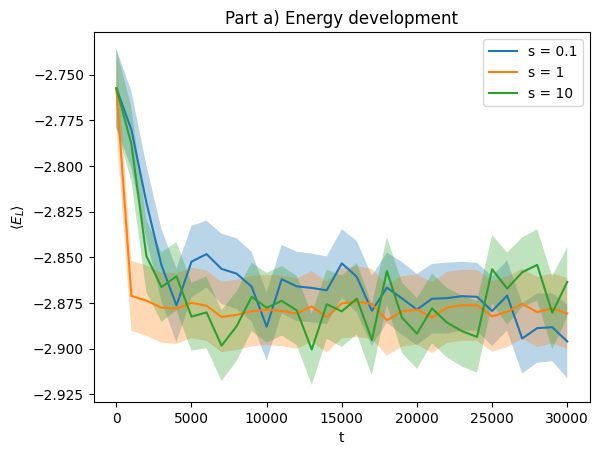

In [434]:
E_avg = np.array(E_avg)
E_std = np.array(E_std)
Probs = np.array(probs)

t = np.linspace(0,N,E_avg.shape[1])
for i in range(E_avg.shape[0]):
    plt.fill_between(t, E_avg[i]-E_std[i], E_avg[i]+E_std[i], alpha=0.3)
    plt.plot(t, E_avg[i], label=f"s = {list_s[i]}")
    
plt.title("Part a) Energy development")
plt.xlabel("t")
plt.ylabel(r"$\langle E_L \rangle$")
plt.legend()

In [435]:
E_avg = np.array(E_avg)
E_std = np.array(E_std)
print(pd.DataFrame({"s": list_s, "mean": E_avg[:,-1], "$\sigma$": E_std[:,-1]}))

      s      mean  $\sigma$
0   0.1 -2.896061  0.020183
1   1.0 -2.880710  0.019355
2  10.0 -2.863469  0.019123


Text(0, 0.5, 'Frequency')

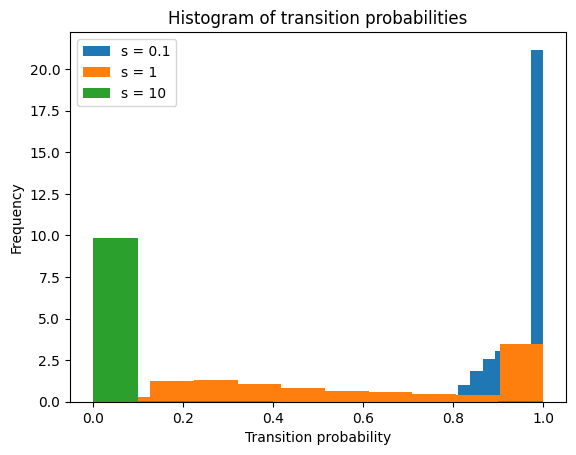

In [445]:
tp_0 = [np.min([1, i]) for i in Probs[0]]
tp_1 = [np.min([1, i]) for i in Probs[1]]
tp_2 = [np.min([1, i]) for i in Probs[2]]

plt.hist(tp_0, bins=10, density=True, label="s = 0.1")
plt.hist(tp_1, bins=10, density=True, label="s = 1")
plt.hist(tp_2, bins=10,density=True, label="s = 10")
plt.legend()
plt.title("Histogram of transition probabilities")
plt.xlabel("Transition probability")
plt.ylabel("Frequency")

The mean energies for $s=1$ are much less fluctuating around the equilibrium than the others. Moreover, the distribution of transition probabilities for $s=10$ is very small and for $s=0.1$ very often at 1. Therefore, for the large step sizes almost no trial state is accepted, making the simulation converge slowly, while for $s=0.1$ the transition happens almost randomly (i.e. independent of the energy difference), making the convergence also very slow. In the following tasks, $s$ is therefore set to 1.

# Problem b

In [335]:
N_b = 10000
list_alpha = [0.0, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]

E_avg_alpha = []
E_std_alpha = []

for a in tqdm(list_alpha):
    simulation_a, pa = metropolis_algorithm(R, num_trials=N_b, s=1, alpha=a, beta=0.5, kappa=2, disable_tqdm=True)
    E_avg_a, E_std_a = energy_statistics(simulation_a, n, alpha=a, beta=0.5, kappa=2, disable_tqdm=True)
    E_avg_alpha.append(E_avg_a)
    E_std_alpha.append(E_std_a)
    
E_avg_alpha = np.array(E_avg_alpha)
E_std_alpha = np.array(E_std_alpha)

100%|██████████| 7/7 [07:47<00:00, 66.76s/it]


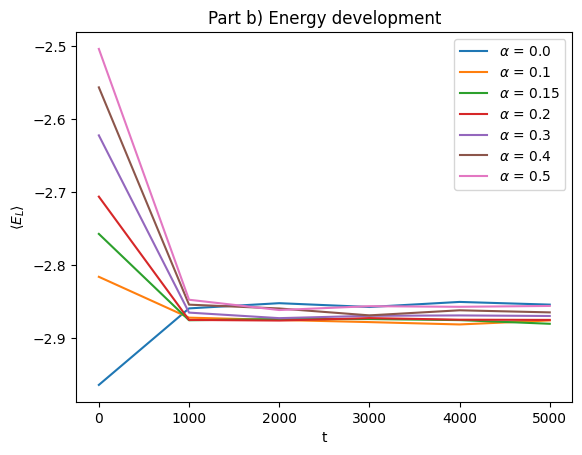

In [437]:
t_b = np.arange(E_std_alpha.shape[1])*1000
for i in range(len(list_alpha)):
    plt.plot(t_b, E_avg_alpha[i], label= rf"$\alpha$ = {list_alpha[i]}")
    
plt.title("Part b) Energy development")
plt.xlabel("t")
plt.ylabel(r"$\langle E_L \rangle$")
plt.legend()

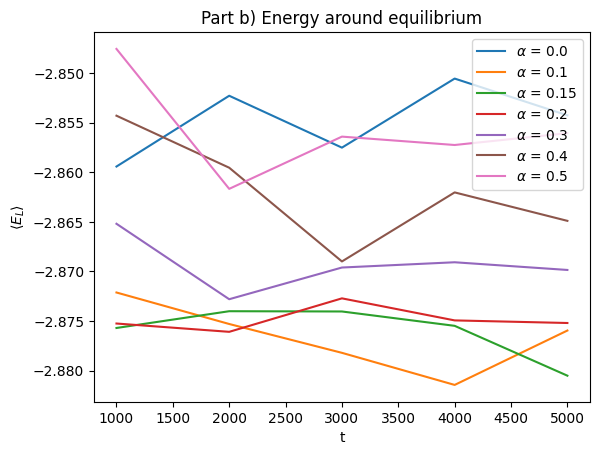

In [438]:
t_b = np.arange(1, E_std_alpha.shape[1])*1000
for i in range(len(list_alpha)):
    plt.plot(t_b, E_avg_alpha[i][1:], label= rf"$\alpha$ = {list_alpha[i]}")
    
plt.title("Part b) Energy around equilibrium")
plt.xlabel("t")
plt.ylabel(r"$\langle E_L \rangle$")
plt.legend()

The plots in b) suggest strongly to choose $n_{equilibrium} = 1000$.

In [439]:
n_equilibrium = 1000 

# Problem c

In [356]:
N_c = 10000 

In [454]:
def energy_statistics_c(simulation, equilibration_time, alpha=0.15, beta=0.5, kappa=2, disable_tqdm=False):
    energies = []
    num_simulation_steps = simulation.shape[0]
    e_0 = [energy_local(simulation[0,i], simulation[0,i+M], alpha=alpha, beta=beta, kappa=kappa) for i in range(M)]
    for time in tqdm(range(equilibration_time, num_simulation_steps), disable=disable_tqdm):
        energies_t = []
        for i in range(M):
            e_i = energy_local(simulation[time,i], simulation[time,i+M], alpha=alpha, beta=beta, kappa=kappa)
            energies_t.append(e_i)
        energies.append(energies_t)
    e_avg_t = np.mean(energies)
    e_var_t = np.std(energies)
    return np.array(e_avg_t), np.sqrt(1/(M-1))*np.array(e_var_t)

In [357]:
list_alpha_c = np.linspace(0,0.5,50)

E_avg_alpha_c = []
E_std_alpha_c = []

for alpha in tqdm(list_alpha_c):
    simulation_a, _ = metropolis_algorithm(R, N_c, s=1, alpha=alpha, beta=0.5, kappa=2, disable_tqdm=True)
    E_avg_a, E_std_a = energy_statistics_c(simulation_a, n_equilibrium, alpha=alpha, beta=0.5, kappa=2, disable_tqdm=True)
    E_avg_alpha_c.append(E_avg_a)
    E_std_alpha_c.append(E_std_a)
    
E_avg_alpha_c = np.array(E_avg_alpha_c)

100%|██████████| 50/50 [1:50:15<00:00, 132.31s/it]


Text(0.5, 1.0, 'Part c): Mean energy for different $\\alpha$')

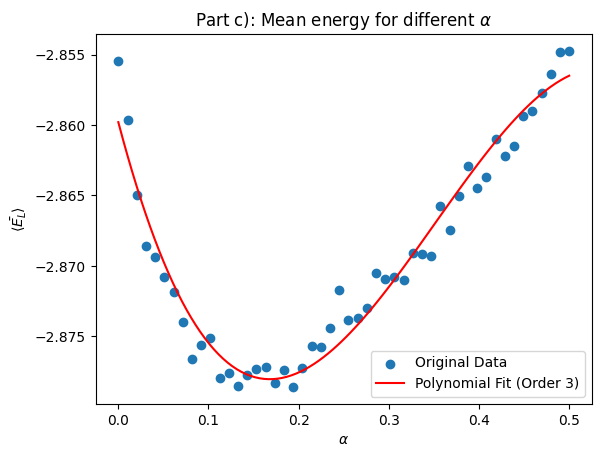

In [367]:
coefficients = np.polyfit(list_alpha_c, E_avg_alpha_c, 3)
polynomial_func = np.poly1d(coefficients)
x_fit = np.linspace(min(list_alpha_c), max(list_alpha_c), 100)
y_fit = polynomial_func(x_fit)

plt.scatter(list_alpha_c, E_avg_alpha_c, label='Original Data')
plt.plot(x_fit, y_fit, label='Polynomial Fit (Order 3)', color='red')
plt.legend()

plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\langle \bar{E_{L}} \rangle$")
plt.title(r"Part c): Mean energy for different $\alpha$")

Text(0.5, 1.0, 'Part c): Standard deviations for different $\\alpha$')

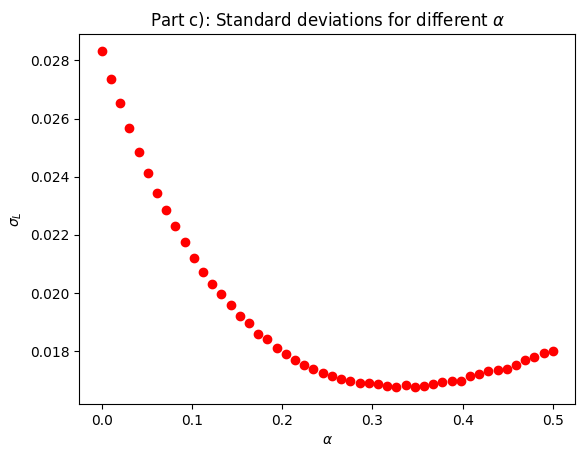

In [431]:
for i, alpha in enumerate(list_alpha_c):
    plt.plot(list_alpha_c[i], E_std_alpha_c[i]/np.sqrt(M-1), "ro", label = rf"$\alpha$ = {alpha}")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$ \sigma_{L} $")
plt.title(r"Part c): Standard deviations for different $\alpha$")

In [448]:
#Determining the alpha that minimizes the energy
alpha_min = np.round(list_alpha_c[np.argmin(E_avg_alpha_c)], 2)
print(alpha_min, np.min(E_avg_alpha_c), E_std_alpha_c[np.argmin(E_avg_alpha_c)])

0.19 -2.8785920888881664 0.31319875654260476


The following minimum is obtained:
$\alpha_{min} \approx 0.19$
$\langle \bar{E_{L}} \rangle_{min} \approx -2.88$
$\sigma_{min} \approx 0.31$

Since it minimizes the energy, it is chosen for the next steps.

In [368]:
coefficients

array([-0.90200444,  0.94959283, -0.2427015 , -2.85979314])

# Problem d

In [422]:
alpha_optimal = alpha_min

list_kappa = np.linspace(1.7, 2.2, 10)

E_avg_kappa = []
E_std_kappa = []

for k in tqdm(list_kappa):
    simulation_k, _ = metropolis_algorithm(R, 10000, s=1, alpha=alpha_optimal, beta=0.5, kappa=k, disable_tqdm=True) 
    E_avg_k, E_std_k = energy_statistics_c(simulation_k, n_equilibrium, alpha=alpha_min, beta=0.5, kappa=k, disable_tqdm=True)
    E_avg_kappa.append(E_avg_k)
    E_std_kappa.append(E_std_k)

E_avg_kappa = np.array(E_avg_kappa)
E_std_kappa = np.array(E_std_kappa)

100%|██████████| 10/10 [22:30<00:00, 135.03s/it]


Text(0.5, 1.0, 'Part d): Mean energy for different $\\kappa$')

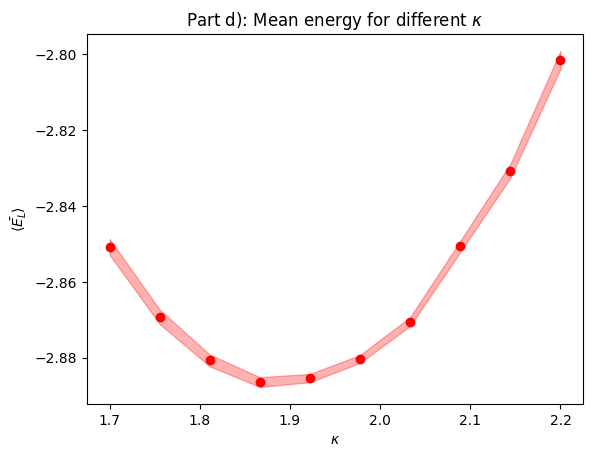

In [425]:
plt.fill_between(list_kappa, E_avg_kappa+E_std_kappa/(M-1), E_avg_kappa-E_std_kappa/(M-1), color="r", alpha=0.3) #Todo: if run again, do not divide by M-1
plt.plot(list_kappa, E_avg_kappa, "ro")
plt.xlabel(r"$\kappa$")
plt.ylabel(r"$\langle \bar{E_{L}} \rangle$")
plt.title(r"Part d): Mean energy for different $\kappa$")

Text(0.5, 1.0, 'Part d): Standard deviations for different $\\kappa$')

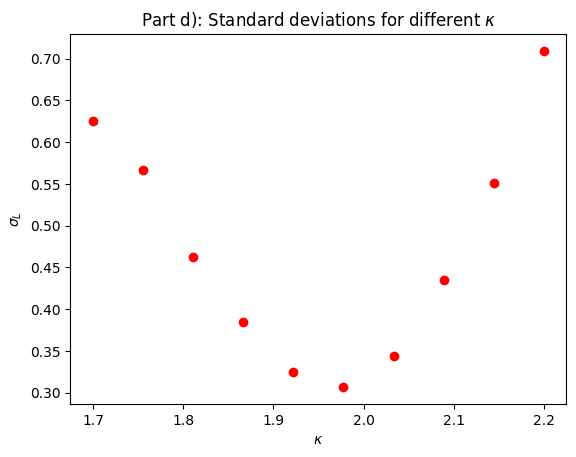

In [430]:
plt.plot(list_kappa, E_std_kappa, "ro")
plt.xlabel(r"$\kappa$")
plt.ylabel(r"$\sigma_{L}$")
plt.title(r"Part d): Standard deviations for different $\kappa$")

In [449]:
kappa_min = np.round(list_kappa[np.argmin(E_avg_kappa)], 2)
print(kappa_min, np.min(E_avg_kappa), E_std_kappa[np.argmin(E_avg_kappa)])

1.87 -2.8864392824010436 0.38443787388845824


The minimum from c was:
$\alpha_{min} \approx 0.19$,
$\langle \bar{E_{L}} \rangle_{min} \approx -2.88$,
$\sigma_{min} \approx 0.31$

Now we have:
$\kappa_{min} \approx 1.87$,
$\langle \bar{E_{L}} \rangle_{min} \approx -2.89$,
$\sigma_{min} \approx 0.38$

Thus, the optimization of $\kappa$ yields a further minimization of the energy. However, the standard deviation is increased. 

# Problem e

In [455]:
beta_e = 0.38
alpha_e = 0.18 
kappa_e = 1.85
simulation_e, _ = metropolis_algorithm(R, N_c, s=1, alpha=alpha_e, beta=beta_e, kappa=kappa_e)
E_avg_e, E_std_e = energy_statistics_c(simulation_e, n_equilibrium, alpha=alpha_e, beta=beta_e, kappa=kappa_e, disable_tqdm=True)

100%|██████████| 10000/10000 [01:43<00:00, 97.02it/s]


In [456]:
print(E_avg_e, E_std_e)

-2.8919346557050853 0.02110229819638231


In [458]:
E_exp = -2.90338583
print(E_exp, E_avg_e-E_std_e)

-2.90338583 -2.9130369539014676


Compared to the minimal energies in c) and d), here the energy is even further decreased. It even lies in the neighborhood of the experimental value of the energy. Therefore, we can assume that the energy is minimized by this choice of parameters.

# Problem f

See after h)

# Problem g

Dear tutors, it was not clear to me here if I should sample the random fluctuations from a uniform or normal distribution (like in the DMC). I believe that this would be a useful hint on the sheet. I chose the normal distribution here, because it gives reasonable energies for some time steps, but it took me a very long time to figure that out (before the energy was more accurate for larger $\Delta t$, but overall not as "good" as now).

In [495]:
list_delta_t = [0.01, 0.05, 0.1, 0.2, 1.0]
E_avg_dt = []
E_std_dt = []

for dt in tqdm(list_delta_t):
    simulation_dt, _ = metropolis_algorithm(R, 10000, 1, alpha_e, beta_e, kappa_e, use_FP = True, delta_t=dt, disable_tqdm=True)
    E_avg_t, E_std_t = energy_statistics_c(simulation_dt, n_equilibrium, alpha=alpha_e, beta=beta_e, kappa=kappa_e, disable_tqdm=True)
    E_avg_dt.append(E_avg_t)
    E_std_dt.append(E_std_t)
    
E_avg_dt = np.array(E_avg_dt)
E_std_dt = np.array(E_std_dt)

100%|██████████| 5/5 [16:42<00:00, 200.49s/it]


Text(0.5, 1.0, 'Part g): Standard deviations for different $\\Delta \\tau$')

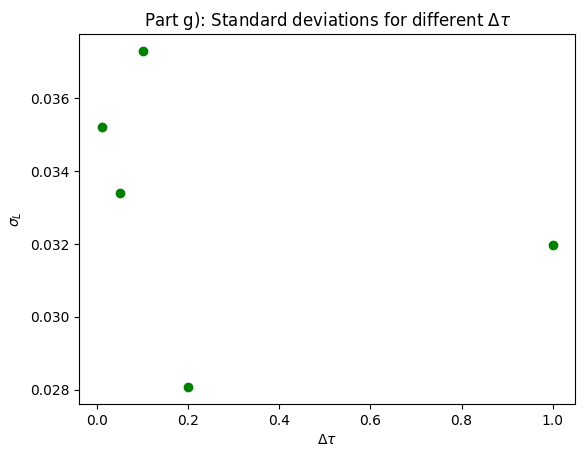

In [496]:
plt.plot(list_delta_t, E_std_dt, "go")
plt.xlabel(r"$\Delta \tau$")
plt.ylabel(r"$ \sigma_{L}$")
plt.title(r"Part g): Standard deviations for different $\Delta \tau$")

In [497]:
print(pd.DataFrame({r"time step": list_delta_t, "mean": E_avg_dt, "standard deviation": E_std_dt}))

   time step      mean  standard deviation
0       0.01 -2.967627            0.035201
1       0.05 -2.927584            0.033383
2       0.10 -2.909245            0.037296
3       0.20 -2.899860            0.028073
4       1.00 -3.003738            0.031955


The energy most accurate compared to $E_{exp}=-2.90338583$ is for $\Delta \tau = 0.10$ with $\langle E \rangle = -2.91 \pm 0.04$. This aligns well with the result from e). The error in e) was strangely smaller than here. Normally one would expect a smaller error for the FP-VMC, because with increasing time differences between the simulation steps, we make a larger error in the approximations (the simulation is based on the first order Baker-Campbell-Hausdorff formula, i.e. we make an error of $O(\Delta \tau^2$)). It is also not correct that some energies are smaller than the experimental ground state of Helium. Therefore, I assume that something is wrong in the implementation of the FP-VMC.

# Problem h

We choose $\Delta \tau = 0.1$ for part h, as this was the best value in g).

In [500]:
simulation_dt, _ = metropolis_algorithm(R, N_c, 1, alpha_e, beta_e, kappa_e, use_FP = True, delta_t=0.1)
E_avg_t, E_std_t = energy_statistics_c(simulation_dt, n_equilibrium, alpha=alpha_e, beta=beta_e, kappa=kappa_e)


100%|██████████| 9001/9001 [00:31<00:00, 289.82it/s]


Text(0, 0.5, 'Frequency')

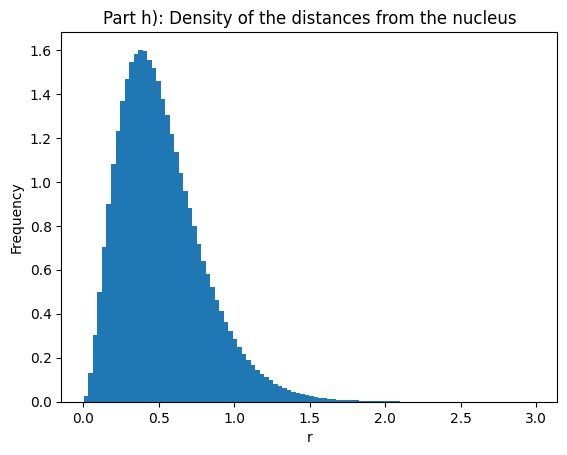

In [501]:
dists = []

for time in range(n_equilibrium, N_c):
    for i in range(2*M):
        l = np.linalg.norm(simulation_dt[time][i])
        dists.append(l)
        
hist = plt.hist(dists, bins=100, density=True)
plt.title("Part h): Density of the distances from the nucleus")
plt.xlabel("r")
plt.ylabel("Frequency")

The distribution shows that the electrons have a strong preference for a certain distance to the nucleus. This is reasonable, because the simulation drives the walkers into the ground state with fixed ground state energy and corresponding energy.

Text(0, 0.5, 'Frequency')

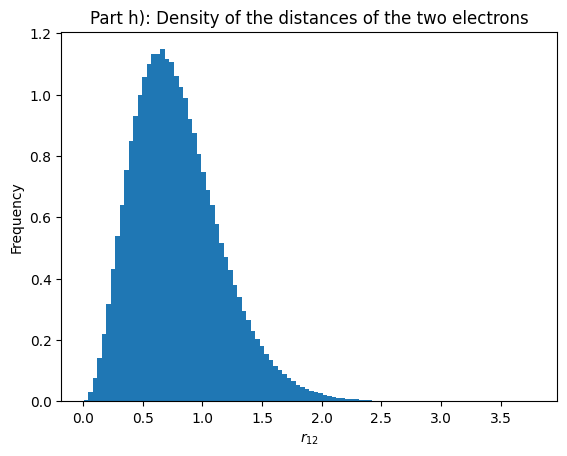

In [502]:
dists_electrons = []

for time in range(n_equilibrium, N_c):
    for i in range(M):
        l = np.linalg.norm(simulation_dt[time][i]-simulation_dt[time][i+M])
        dists_electrons.append(l)
        
hist = plt.hist(dists_electrons, bins=100, density=True)
plt.title("Part h): Density of the distances of the two electrons")
plt.xlabel("$r_{12}$")
plt.ylabel("Frequency")

The distribution show a clear preferred distance of the two electrons. For smaller distances, the coulomb force is pushing the particles apart. The distance of the electrons is moreover about double the distance of the electrons from the nucleus, i.e. the nucleus is directly between them. This is energy efficient, because the nucleus shields the coulomb repelling.